<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/3_Clasificadores_Desemp_ConceptosBasicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificadores - conceptos básicos**


*Códigos referencia del libro Hands-On Machine Learning with Scikit-Learn and Tensor Flow 2017 (Cap 3) -- Aurélien Géron

# Configuraciones básicas

Preparar módulos de Python:

In [1]:
import numpy as np #importar numpy
import os

# asesgurar mismos resultados para presentación se deja semilla fija
np.random.seed(42)

# gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#crear carpeta con resultados
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import warnings #eliminar warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# MNIST : "Hello world" de clasificación 

- La base de datos [Mnist](http://yann.lecun.com/exdb/mnist/) contiene imágenes los digitos del 0 al 9 escritos a mano alzada por muchas personas.

- Primero se ordenan los datos para asegurar repetibilidad de los experimentos. Note que se ordenan por separado el conjunto de entrenamiento (primeras 60000 imágenes) y el conjunto de evaluación (las restantes 10000).

In [2]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X = np.r_[X_train,X_test]
y = np.r_[y_train,y_test]
X = X/255. #se normalizan datos de 0 a 1
X = X.reshape(X.shape[0],-1) #se fijan imágenes a 784 atributos por concatenación
print(X.shape,y.shape)

11501568/11490434 [==============================] - 0s 0us/step
(70000, 784) (70000,)


- La base de datos Mnist consta de 70000 muestras, con imágenes de 28 x 28 = 784 (atributos) en escala de grises.

- Se define la base de datos estructurada muestras x atributos y el vector etiquetas.

- Se grafica un ejemplo de la base de datos como imagen

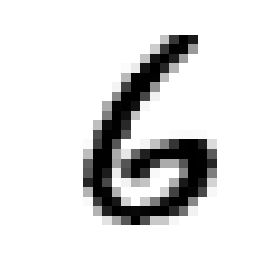

In [3]:
some_digit = X[6000] #alguna muestra
some_digit_image = some_digit.reshape(28, 28) # se reorgniza el vector de 784 en imagen de 28 x 28
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest") #se gráfica imágen con interpolador de vecinos para mejorar visualización
plt.axis("off") #quitar rejilla
plt.tight_layout() #ajustar figura
plt.savefig('results/some_digit_plot.pdf', format='pdf', dpi=300)
plt.show()

In [6]:
def plot_digit(data): #función graficar dígito
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

- Se presentan algunos ejemplos por clase para ilustrar la variabilidad en las formas de los digitos.

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)#muestras por fila
    images = [instance.reshape(size,size) for instance in instances] #identificar cantidad de imagenes a pixels
    n_rows = (len(instances) - 1) // images_per_row + 1 #redondeo para determinar num de filas
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty))) #crear arreglo completo para las imágenes
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1)) #indexar imágenes y concatenar filas por clase
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

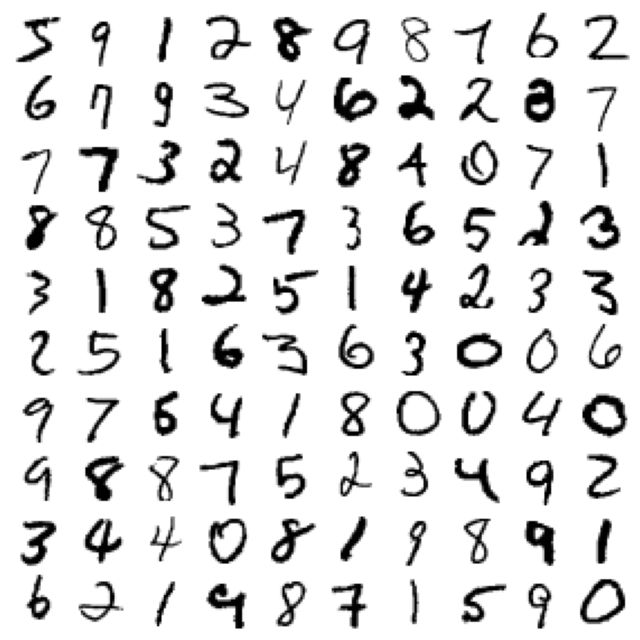

(100, 784)

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]] #concatenar por filas
plot_digits(example_images, images_per_row=10)
plt.tight_layout()
plt.savefig('results/full_digits_plot.pdf', format='pdf', dpi=300)
plt.show()
np.shape(example_images)

# Definir conjuntos de entrenamiento y evaluación.

- Se toman las primeras 60000 imágenes como entrenamiento

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #particionar train y test

- Para asegurar muestras i.i.d se barajan las muestras

In [10]:
shuffle_index = np.random.permutation(60000) #permutación datos
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Ejemplo clasificador binario

- Primero se ilustra el concepto de clasificación a partir del proble 5 vs no 5.

In [11]:
y_train_5 = (y_train == 5) # clasificador 5 vs NO 5
y_test_5 = (y_test == 5) 

- Se probará el [clasificador SGD](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), perceptrón simple

In [12]:
from sklearn.linear_model import SGDClassifier #clasificador lineal por gradiente

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)#definir objeto sgd
sgd_clf.fit(X_train, y_train_5)#ajustar modelo

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

2

In [18]:
some_digit = X_test[np.where(y_test==False)[0][0]]
sgd_clf.predict([some_digit]) #clasificar dígito 5

array([False])

- Es preciso aclarar que el caso 5 vs no 5 presenta un alto desbalance de los datos.

- Aprox. el 90% de las muestras pertenecerán al grupo no 5.

- Revisemos el conteo de las etiquetas:

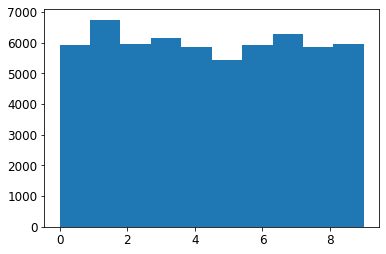

In [19]:
plt.hist(y_train) #histograma etiquetas
plt.show()

- Si realizamos una validación cruzada simple en términos del acierto de clasificación, el sistema *paracerá* clasificar bien, dado que el acierto es un promedio simple para cuando la predicción iguala la etiqueta objetivo:

$$ACC = \frac{1}{N}\sum_{n=1}^N \delta(y_n-\hat{y}_n)$$
donde $\delta(\cdot)$ es la [función delta](https://es.wikipedia.org/wiki/Delta_de_Dirac) y $y_n,\hat{y}_n\in\mathbb {Z}$ representan las etiquetas originales y estimadas, respectivamente.

-Sin embargo, es claro que el modelo se sobreajusta a clasificar no 5.


In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") #evaluar clasificador según acierto

array([0.9642 , 0.96065, 0.97055])

- Incluso, se aplicamos una vaildación cruzada con estratificación, el desbalance es muy fuerte y el sistema sigue sobreajustándose.

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) #generar partición balanceada

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9642
0.96065
0.97055


# Clasificador tonto nunca 5.

- En este caso, si revisamos solo es ACC, podemos definir un clasificado *tonto* que siempre arroje no 5 como predicción, y el ACC seguirá por encima del 90%.

In [22]:
from sklearn.base import BaseEstimator #clase básica para construir modelos en scikitlearn
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): #métddo de ajuste
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)#método de predicción

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

# La matriz de confusión

- Si revisamos en detalle las predicciones, nos daremos cuenta que aunque el acierto es alto, en clases con pocos datos las predicciones no son correctas.

- Para ello podemos utilizar la matriz de confusión como alternativa.

- Primero estimaremos las salidas bajo validación cruzada, y calcularemos la matriz de confusión.

- El método cross_val_predict devuelve un vector de salidas igual a la cantidad de muestras de entrada, fijando como salida el valor de predicción de cada muestra cuando dicha muestra estuvo en el conjunto de evaluación.

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #genera predicción de cada muestra según su aparición en validación

In [25]:
y_train_pred.shape

(60000,)

In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54107,   472],
       [ 1620,  3801]])

- La matriz de confusión binaria, nos permite revelar la cantidad de verdaderos negativos, falsos positivos, falsos negativos y verdaderos positivos.

$$confusion-matrix=\begin{bmatrix}True Negative & False Positive \\
False Negative & True Positive
\end{bmatrix}$$

- Es calro que la clase 5 no fue muy bien clasificada.

- Una clasificación perfecta deberá arrojar una matriz de confusión tipo diagonal.

In [27]:
y_train_perfect_predictions = y_train_5

In [28]:
print(confusion_matrix(y_train_5, y_train_perfect_predictions))
#[[TN FP][FN TP]]

[[54579     0]
 [    0  5421]]


- A partir de la matríz de confusión se pueden generar algunas otras medidas relacionadas con los conceptos de probabilidad de detección, false alarma y curva ROC (como extensiones a los conceptos básicos en teoría de detección).

In [29]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # TP/(TP+FP)

0.8895389655979405

$$PrecisionScore=\frac{TruePositive}{TruePositive+FalsePositive}$$



In [30]:
recall_score(y_train_5, y_train_pred) # TP/(TP+FN)

0.7011621472053127

$$RecallScore=\frac{TruePositive}{TruePositive+FalseNegative}$$

In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # 2/(1/pre + 1/rec) = TP/(TP + (FN+FP)/2)

0.7841964101506087

$$f1score=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}=\frac{TruePositive}{TruePositive+\frac{FalseNegative+FalsePositive}{2}}$$

# Score de decisión

- En muchas ocasiones, en problemas de clasificación, la robustez del modelo puede cuantificarse mejor a partir del score (generalmente definido como una probabilidad o una distancia a la forntera de decisión), en lugar de la umbralización del mismo = etiqueta.

In [32]:
y_scores = sgd_clf.decision_function([some_digit]) #estimar score del dígito de prueba
y_scores

array([-10.65652793])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) #etiqueta como umbralización del score

In [34]:
y_some_digit_pred

array([False])

- Si cambiamos el umbral, indirectamente movemos la frontera de decisión.

In [37]:
threshold = -11#cambiar umbral para sesgar clasificador según precisión o exahustividad
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- Podemos utilizar cross_val_predict fijando decision function para guardar el score de cada muestra.

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

- El score nos permite cuantificar la estabilidad del modelo ante variaciones del umbral (cambios alrededor de la frontera de decisión).

In [39]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) #estimar precisión y exahustividad variando los umbrales

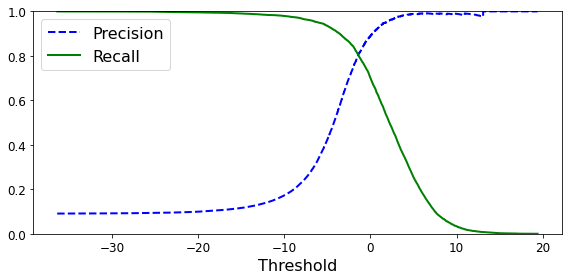

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.tight_layout()
plt.savefig('results/precision_recall_vs_threshold_plot.pdf', format='pdf', dpi=300)
plt.show()

- Según la gráfica anterior, podriamos jugar con el umbral para favorecer el rendimiento en recall o exahustividad según la necesidad.

In [41]:
(y_train_pred == (y_scores > 0)).all() #revisar si todos cumplen condición
#por defecto scikitlearn evalua clasificador con umbral en 0

True

In [44]:
y_train_pred_90 = (y_scores > 15) # nueva frontera cambiando el umbral 

In [45]:
precision_score(y_train_5, y_train_pred_90)

1.0

In [46]:
recall_score(y_train_5, y_train_pred_90) # por nuevo umbral se ajusta exahustividad

0.002767017155506364

- Para visualizar de forma compacta el recall y precision, se puede generar una curva uniendo dichos valores para cada umbral fijado.

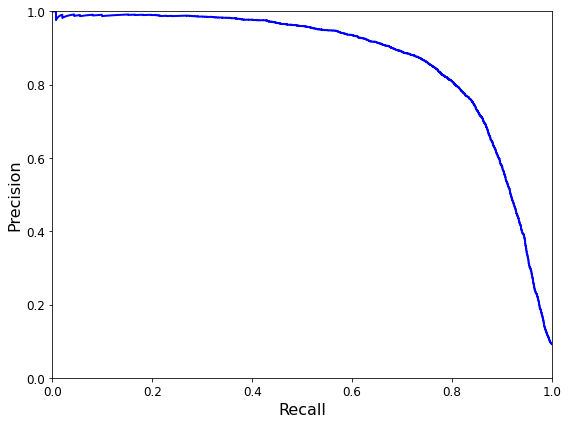

In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.tight_layout()
plt.savefig('results/precision_vs_recall_plot.pdf', format='pdf', dpi=300)
plt.show()

# Curva ROC: reciever operating characteristic
Característica Operativa del Receptor

- Generalmente, en problemas de analítica de datos se utiliza la [curva ROC](https://es.wikipedia.org/wiki/Curva_ROC) bajo el mismo principio de recall vs precision, y se relaciona con los conceptos de sensibilidad y especificidad (muy comunes en el área de salud).

$$FalsePositiveRate = \frac{FalsePositive}{\#samples}=1-specificity$$

$$TruePositiveRate = \frac{TruePositive}{TruePositive+FalseNegative}=sensitivity$$

- Los valores se cálculan variando el umbral de decisión del clasificador para generar una curva, la curva ROC

- **Nota**: recuerde que:

$$confusion-matrix=\begin{bmatrix}True Negative & False Positive \\
False Negative & True Positive
\end{bmatrix}$$

In [48]:
from sklearn.metrics import roc_curve
#matriz confusión = #[[TN FP][FN TP]]
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # Fpr = FP/N -> 1 - especificidad , Tpr = TP/(TP+FN) -> exahustividad (recall, sensibilidad)
#especificidad = TN/(TN+FP)

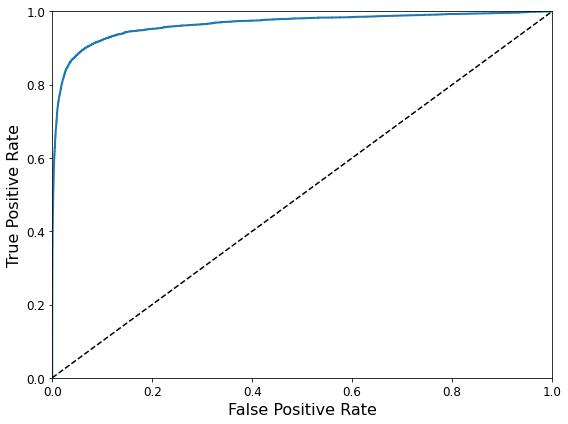

In [49]:
def plot_roc_curve(fpr, tpr, label=None): #función para graficar curva roc
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.tight_layout()
plt.savefig('results/roc_curve_plot.pdf', format='pdf', dpi=300)
plt.show()

- Dado que la curva ROC genera valores valores (medidas de desempeño), se puede calcular el área bajo dicha curva (AUC) para generar un único valor de rendimiento.

- El clasificador ideal presentará $AUC=1$.

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)#clasificador perfecto AUC = 1; clasificador aleatorio AUC = 0.5

0.964698291132642

- Comparemos la curva ROC del SGD contra un clasificador más completo.

In [51]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

- **Nota**: Se debe revisar en la documentación el principio del score del clasificador usado: distancia a frontera o probabilidad de membresia de clase.

In [52]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

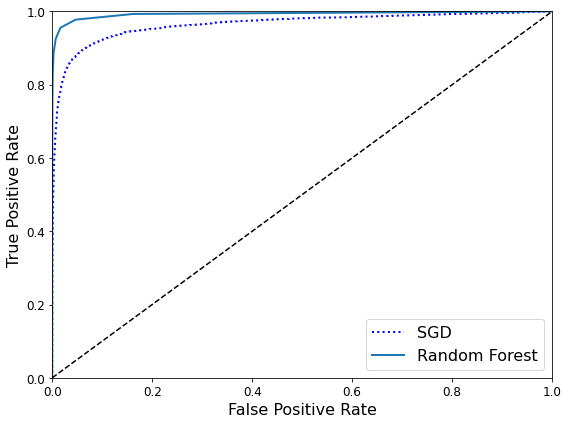

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.savefig('results/roc_curve_comparison_plot.pdf', format='pdf', dpi=300)
plt.show()

**Nota**: Se recomienda usar la curva precisión vs exahustividad cuando la clase positiva es escasa o cuando es más importante en la aplicación evitar los falsos positivos que los falsos negativos, y la curva ROC en caso contrario (es más importante evitar los falsos negativos que los falsos positivos, ej. problemas de salud).

In [54]:
roc_auc_score(y_train_5, y_scores_forest)#mejor AUC que SGD

0.9928284644819227

# Clasificación multiclase

- Hasta el momento ilustramos los conceptos básicos de clasificación para el caso binario (dos clases).

- Sin embargo, en la mayoria de los casos, se cuenta con más de dos clases. En este caso, la tarea original de Mnist se centra en detectar cada uno de los 10 digitos.

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # si el clasificador es netamente binario aplica estrategia one vs all, 
#a excepción de las svm que aplica one vs one para evitar costo computacional

array([0], dtype=uint8)

- En este caso se sklearn aplica una estrategia one vs all para clasificar las 10 clases, y como score presenta la distancia a la frontera para cada combinación.

In [56]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ 15.98972112, -21.84918528,  -8.61841368, -11.68303912,
        -18.26645303, -10.24810383,  -4.21485126, -12.48566092,
        -22.82495088, -11.80545548]])

- Si el dato esta lejos de la frontera el clasificador está más seguro de la decisión.

In [57]:
np.argmax(some_digit_scores) # máximo score para 5 vs all

0

In [58]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

- También, podemos utilizar la extensión one vs one y comparar resultados.

In [60]:
from sklearn.multiclass import OneVsOneClassifier #extensión a one vs one
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0], dtype=uint8)

In [61]:
len(ovo_clf.estimators_) #se generan 45 combinaciones C(C-1)/2

45

- Para el caso de clasificadores con interpretación probabilística, el score arrojará un vector de probabilidades con la probabilidad de membresia a cada grupo.

In [62]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit]) #algunos clasificadores ya incluyen multiclase desde el score o probabilidad de membresia

array([0], dtype=uint8)

In [63]:
forest_clf.predict_proba([some_digit])

array([[0.9, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ]])

- Es claro que un clasificador multiclase es más complejo de entrenar.

- Se define como cota mínima de probabilidad de acierto 1/#clases.

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") # un clasificador aleatorio obtendria un 0.1 dado que C = 10

array([0.85705, 0.88855, 0.8752 ])

- Recuerde que los rangos de variación de los atributos pueden afectar la construcción de la frontera de decisión, por ende, es conveniente normalizar los datos antes de entrenar los clasificadores.

In [65]:
from sklearn.preprocessing import StandardScaler #el preproceso puede ayudar a mejorar la clasificación
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91155, 0.91005, 0.9095 ])

# Matriz de confusión para multiclase

- En este caso se compara cada clase (positiva) respecto a las C-1 restantes, buscando identificar cuantas veces confundio el grupo de interés con cada uno de los grupos restantes.

**Nota**: en muchas ocasiones es preferible visualizar la matriz de confusión en porcentaje.

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred,normalize='true')#normaliza sobre suma de filas
conf_mx

array([[9.66064494e-01, 3.37666723e-04, 4.72733412e-03, 1.51950025e-03,
        1.35066689e-03, 8.27283471e-03, 8.61050144e-03, 1.85716698e-03,
        6.92216782e-03, 3.37666723e-04],
       [2.96647879e-04, 9.63215663e-01, 6.97122516e-03, 3.41145061e-03,
        8.89943637e-04, 6.22960546e-03, 7.41619697e-04, 1.48323939e-03,
        1.48323939e-02, 1.92821121e-03],
       [8.55991944e-03, 6.21013763e-03, 8.99630749e-01, 1.47700571e-02,
        1.37630077e-02, 3.86035582e-03, 1.61127895e-02, 9.39912722e-03,
        2.50083921e-02, 2.68546492e-03],
       [8.31838199e-03, 6.03490458e-03, 2.43027239e-02, 8.67395205e-01,
        3.26211059e-04, 4.04501713e-02, 6.03490458e-03, 9.29701517e-03,
        2.18561409e-02, 1.59843419e-02],
       [3.25231085e-03, 4.27935638e-03, 6.67579596e-03, 1.36939404e-03,
        9.20575145e-01, 1.19821979e-03, 9.24340979e-03, 4.96405341e-03,
        1.31804177e-02, 3.52618966e-02],
       [1.34661502e-02, 7.74764804e-03, 6.45637336e-03, 3.13595278e-02,
   

In [67]:
def plot_confusion_matrix(matrix):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


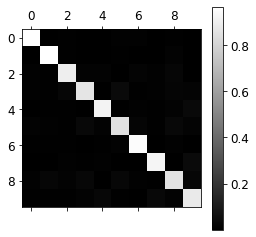

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.tight_layout()
plt.colorbar()
plt.savefig('results/confusion_matrix_plot.pdf', format='pdf', dpi=300)
plt.show()

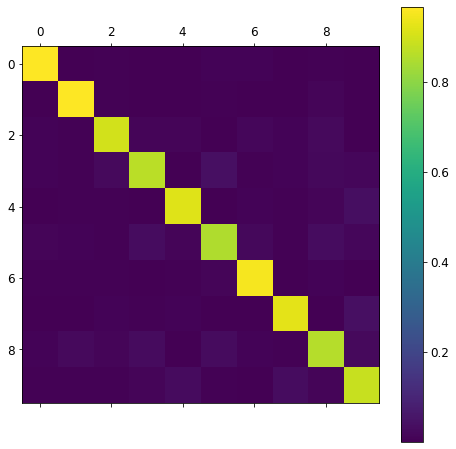

In [69]:
plot_confusion_matrix(conf_mx) # matriz de confusión con barra de colores
plt.savefig('results/confusion_matrix_plot_color.pdf', format='pdf', dpi=300)
plt.show()

- Podemos visualizar algunos casos particulares de la matriz de confusión desde las imágenes.

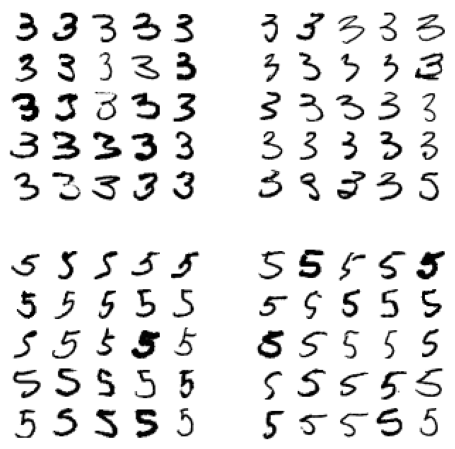

In [70]:
cl_a, cl_b = 3, 5 #analizar errores puntuales
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3 como 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3 como 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5 como 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5 como 5

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig('results/error_analysis_digits_plot.pdf', format='pdf', dpi=300)
plt.show()

# Ejercicio:

- Consulte en que consiste el clasificador de vecinos más cercanos en sklearn (ver [documentación knn](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) y [knn sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)).

- Realice una comparación entre los clasificadores SGD, RandomForest implementados en el cuaderno y Knn con distancia Euclídea de un vecino para el problema multiclase Mnist en términos de ACC, f1, y AUC.

# Guardar resultados

In [71]:
from google.colab import files
from datetime import date, datetime
import shutil
#guardar resultados
namefile = str(datetime.now().strftime("%Y_%m_%d_%H_%M_%d"))+'__results'
shutil.make_archive(namefile, 'zip', 'results')
files.download(namefile+'.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>